In [113]:
import numpy as np
import matplotlib.pyplot as plt

### Adjacency Matrix

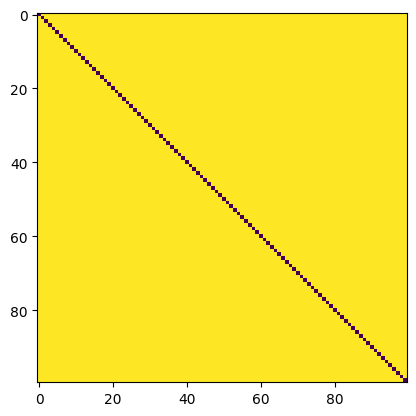

In [125]:
n = 100
dt = 0.001
T = 1

# # default, connected
# A = np.ones((n,n))
# A = np.triu(A, 1)
# A = A + A.T

# Erdos Renyi
p = 1
A = np.random.rand(n,n) # random matrix
A = np.where(A < p, 1, 0) # adjacency matrix
A = np.triu(A, 1) # triangular matrix
A = A + A.T # symmetric matrix

# # Small World
# A = np.zeros((n,n))
# for i in range(n):
#     for j in range(n):
#         if i == j:
#             continue
#         if np.abs(i-j) < 5:
#             A[i,j] = 1
#         elif np.abs(i-j) > n-5:
#             A[i,j] = 1
#         else:
#             A[i,j] = 0


# pop = np.random.randint(25,75) #minimum and maximum population sizes
# A = np.zeros((n,n))
# for i in range(n):
#     for j in range(n):
#         if i == j:
#             A[i,j] = 0
#         elif (i <= pop and j <= pop) or (i > pop and j > pop):
#             A[i,j] = 1
#         else:
#             A[i,j] = 0
# sender = np.random.randint(0,pop+1)
# receiver = np.random.randint(pop+1,99)
# A[sender,receiver] = 1
# A[receiver,sender] = 1

# plot
plt.imshow(A)
plt.show()

### Information Accumulation Process & Kick Weight

In [115]:
mu = np.ones(n) # diffusion, i.e. correct decision
lower = .3
theta = np.array([np.random.uniform(lower,1) for _ in range(n)]) # thresholds
W = lambda: np.random.randn(n) # drift, randon Weiner process

def dydt(A, zeta, mu, w, kicks, dt):
    """Information Accumulation Model
    Args:
        A (nxn): adjacency matrix
        zeta (nx1): drift at current time
        mu (nx1): diffusion
        w (nx1): update weights
        kicks (nx1): kick at current time
        dt (float): time step
    Returns:
        np.ndarray: dydt
    """
    return (mu*dt + np.sqrt(2)*zeta*np.sqrt(dt)) + w*A.dot(kicks)

def dwdt(A, kappa, gamma, w, kicks, dt,tau = 1):
    """Kick weights
    Args:
        A (nxn): adjacency matrix
        kappa (nx1): learning rate
        gamma (nx1): forgetting rate
        w (nx1): update weights
        kicks (nx1): kick at current time
        dt (float): time step
    Returns:
        np.ndarray: dwdt
    """
    return (kappa - w)*dt/tau - gamma*w*np.where(A.dot(np.abs(kicks)) > 1, 1, A.dot(np.abs(kicks)))

def RR(y,tstop,correct=1): #Calculating the reward rate of the given population (accuracy/total time to decide)
    cor = np.sum(y[:,tstop] == correct*np.inf)
    return (cor/len(y[:,tstop]))/tstop

### Simulation

In [116]:
def sim(kappa,gamma,tau,theta,stopcondition=1,function="theta"):
    # initial conditions
    y = np.zeros((n, int(T/dt)))
    w = np.zeros((n, int(T/dt)))

    # initial kick
    kicks = np.zeros(n)

    tstop=int(T/dt)-1

    # simulation
    for t in range(int(T/dt)-1):
        # drift
        zeta = W()
        # update state
        y[:,t+1] = y[:,t] + dydt(A, zeta, mu, w[:,t], kicks, dt)
        # update kick weights
        if function=="theta" or function=="shark":
            w[:,t+1] = w[:,t] + dwdt(A, kappa, gamma, w[:,t], kicks, dt,tau)
        elif function == 1:
            w[:,t+1] = 1
        # update kick
        kp = np.where(y[:,t+1] < np.inf, y[:,t+1], 0) 
        kp = np.where(kp > theta, kp, 0) # TODO this was mu, how to make everything work when we change it? Necessary?
        km = np.where(y[:,t+1] > -np.inf, y[:,t+1], 0)
        km = np.where(km < -theta, km, 0) # TODO this was mu, how to make everything work when we change it? Necessary?
        kicks = kp - km if function=="theta" else np.where(kp, 1, 0) - np.where(km, 1, 0)
        # set to inf
        y[:,t+1] = np.where(y[:,t+1] > theta, np.inf, y[:,t+1])
        y[:,t+1] = np.where(y[:,t+1] < -theta, -np.inf, y[:,t+1])
        # stop condition
        if (np.sum(y[:,t+1] == np.inf) + np.sum(y[:,t+1] == -np.inf))/len(y[:,t+1]) >= stopcondition:
            tstop = t+1
            break

    return RR(y,tstop), np.sum(y[:,tstop] == np.inf), np.sum(y[:,tstop] == -np.inf), tstop, y, w

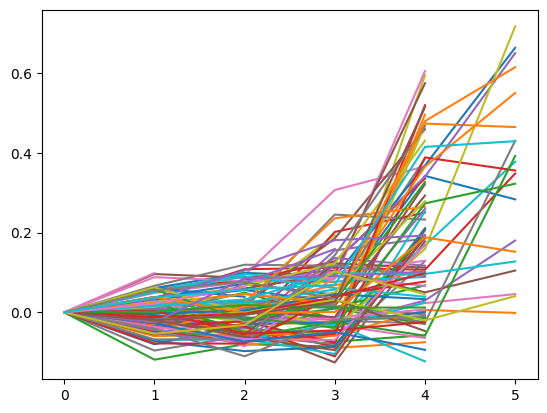

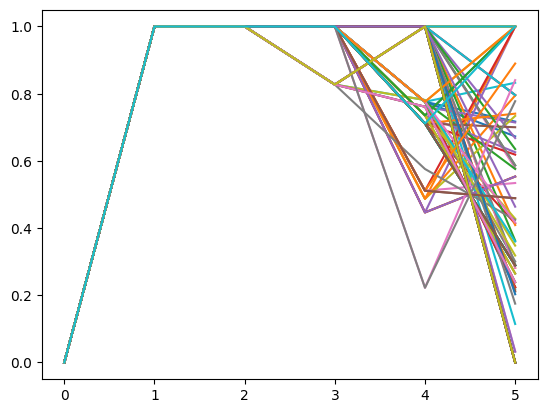

0.16666666666666666 100 0


In [117]:
theta = np.array([np.random.uniform(.1,1) for _ in range(n)]) # thresholds
rr, cor, inc, tstop, yv, wv = sim(1,1,.001,theta,stopcondition=.9,function="theta")
plt.plot(yv[:,:tstop].T)
plt.show()
plt.plot(wv[:,:tstop].T)
plt.show()
print(rr, cor, inc)

In [118]:
def plotting(kappa,gamma,tau,lower,stopcondition=.9,functions=["theta",0]):
    # run sim for multiple values of theta lower bound
    rr1 = {str(a): [] for a in functions}
    c1 = {str(a): [] for a in functions}
    rr25 = {str(a): [] for a in functions}
    c25 = {str(a): [] for a in functions}
    rr75 = {str(a): [] for a in functions}
    c75 = {str(a): [] for a in functions}
    for l in np.linspace(lower,1,20):
        rrt = {str(a): [] for a in functions}
        ct = {str(a): [] for a in functions}
        for _ in range(20):
            theta = np.array([np.random.uniform(l,1) for _ in range(n)]) # thresholds
            for fu in functions:
                rr, cor, _, _, _, _ = sim(kappa,gamma,tau,theta,stopcondition=stopcondition, function=fu)
                rrt[str(fu)].append(rr)
                ct[str(fu)].append(cor)
        for fu in functions:
            rr1[str(fu)].append(np.mean(rrt[str(fu)]))
            c1[str(fu)].append(np.mean(ct[str(fu)]))
            rr25[str(fu)].append(np.percentile(rrt[str(fu)],25))
            c25[str(fu)].append(np.percentile(ct[str(fu)],25))
            rr75[str(fu)].append(np.percentile(rrt[str(fu)],75))
            c75[str(fu)].append(np.percentile(ct[str(fu)],75))

    return rr1, c1, rr25, c25, rr75, c75

In [119]:
# run multiple sims and return average rr and acc
def run(runs,kappa,gamma,tau,lower,stopcondition=.9,function="theta"):
    rrthis = []
    corthis = []
    for _ in range(runs):
        theta = np.array([np.random.uniform(lower,1) for _ in range(n)]) # thresholds
        rr, cor, _, _, _, _ = sim(kappa,gamma,tau,theta,stopcondition,function)
        rrthis.append(rr)
        corthis.append(cor)
    return np.average(rrthis), np.average(corthis)

In [120]:
# perform gradient descent on sim for kappa, gamma, and tau, optimizing for rr
def gradient_descent(runs, kappa, gamma, tau, lower, stopcondition=.9, function="theta", alpha=.01, iterations=100):
    for i in range(iterations):
        rr, cor  = run(runs, kappa, gamma, tau, lower, stopcondition, function)
        if i % 10 == 0:
            print(rr, cor, inc)
        if rr == 0:
            break
        # calculate gradients
        gradkappa = (run(runs, kappa+alpha, gamma, tau, lower, stopcondition, function)[0] - rr)/alpha
        gradgamma = (run(runs, kappa, gamma+alpha, tau, lower, stopcondition, function)[0] - rr)/alpha
        gradtau = (sim(kappa, gamma, tau+alpha, lower, stopcondition, function)[0] - rr)/alpha
        # update parameters
        kappa = kappa - alpha*gradkappa
        gamma = gamma - alpha*gradgamma
        tau = max(0.001,tau - alpha*gradtau)
    return kappa, gamma, tau

In [121]:
# run gradient descent for kappa, gamma, and tau
# kappa, gamma, tau = gradient_descent(20, 1, 1, 1, .1, stopcondition=.9, function="theta", alpha=.01, iterations=100)
# print(kappa, gamma, tau)

In [122]:
# print(kappa,gamma,tau)

1.0026105541904182 0.9504774697972703 0.001


In [126]:
# plot rr and accuracy
rr, c1, rr25, c25, rr75, c75 = plotting(1,1,.001,.1,stopcondition=.9,functions=["theta","shark",0,1])

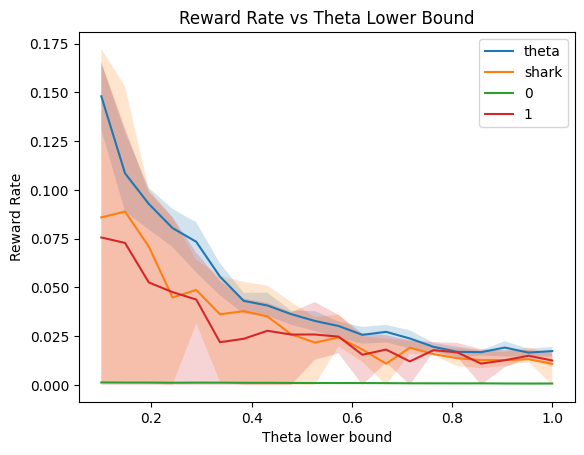

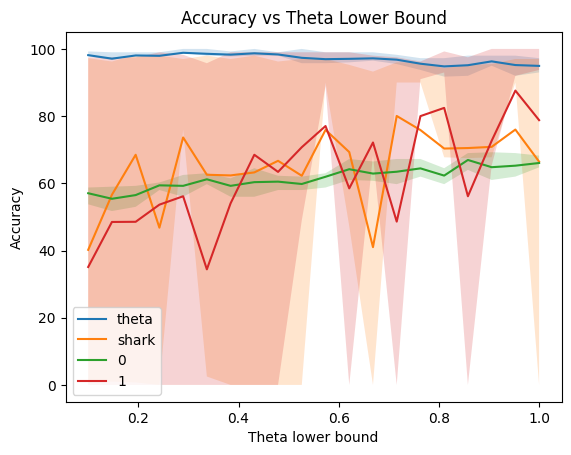

In [124]:
plt.plot(np.linspace(.1,1,20),rr["theta"],label="theta")
plt.plot(np.linspace(.1,1,20),rr["shark"],label="shark")
plt.plot(np.linspace(.1,1,20),rr["0"],label="0")
plt.plot(np.linspace(.1,1,20),rr["1"],label="1")

plt.fill_between(np.linspace(.1,1,20),rr25["theta"],rr75["theta"],alpha=.2)
plt.fill_between(np.linspace(.1,1,20),rr25["shark"],rr75["shark"],alpha=.2)
plt.fill_between(np.linspace(.1,1,20),rr25["0"],rr75["0"],alpha=.2)
plt.fill_between(np.linspace(.1,1,20),rr25["1"],rr75["1"],alpha=.2)

plt.xlabel("Theta lower bound")
plt.ylabel("Reward Rate")
plt.title("Reward Rate vs Theta Lower Bound")
plt.legend()
plt.show()

plt.plot(np.linspace(.1,1,20),c1["theta"],label="theta")
plt.plot(np.linspace(.1,1,20),c1["shark"],label="shark")
plt.plot(np.linspace(.1,1,20),c1["0"],label="0")
plt.plot(np.linspace(.1,1,20),c1["1"],label="1")

plt.fill_between(np.linspace(.1,1,20),c25["theta"],c75["theta"],alpha=.2)
plt.fill_between(np.linspace(.1,1,20),c25["shark"],c75["shark"],alpha=.2)
plt.fill_between(np.linspace(.1,1,20),c25["0"],c75["0"],alpha=.2)
plt.fill_between(np.linspace(.1,1,20),c25["1"],c75["1"],alpha=.2)

plt.xlabel("Theta lower bound")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Theta Lower Bound")
plt.legend()
plt.show()